<a href="https://colab.research.google.com/github/apof/ChAI---GPs---Master-Thesis/blob/main/Neural_Net_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## immport useful utilities from previous coursework
import sys
sys.path.insert(0,'drive/MyDrive/SNLP/')
import utils

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/aluminium_vectors')
aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/aluminium_labels')
aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/aluminium_dates')

copper_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/copper_vectors')
copper_labels = joblib.load('drive/MyDrive/Thesis_Vectors/copper_labels')
copper_dates = joblib.load('drive/MyDrive/Thesis_Vectors/copper_dates')

In [6]:
print(aluminium_inputs.shape)
print(aluminium_labels.shape)
print(aluminium_dates.shape)

print(copper_inputs.shape)
print(copper_labels.shape)
print(copper_dates.shape)

(948, 28, 56)
(948,)
(948,)
(1282, 28, 48)
(1282,)
(1282,)


In [7]:
def align_timeseries(aluminium_inputs,aluminium_labels,aluminium_dates,copper_inputs,copper_labels,copper_dates):
  
  al_in = []
  al_lbl = []
  d = []
  c_in = []
  c_lbl = []

  al_dict = {}

  for i,inp in enumerate(aluminium_inputs):
    al_dict[aluminium_dates[i]] = (inp,aluminium_labels[i])

  for i,inp in enumerate(copper_inputs):
    if(al_dict.get(copper_dates[i]) != None):
      al_in.append(al_dict.get(copper_dates[i])[0])
      al_lbl.append(al_dict.get(copper_dates[i])[1])
      c_in.append(inp)
      c_lbl.append(copper_labels[i])
      d.append(copper_dates[i])

  return np.array(al_in),np.array(al_lbl),np.array(c_in),np.array(c_lbl),d



In [8]:
aluminium_inputs,aluminium_labels,copper_inputs,copper_labels,dates =  align_timeseries(aluminium_inputs,aluminium_labels,aluminium_dates,copper_inputs,copper_labels,copper_dates)

In [9]:
print(aluminium_inputs.shape)
print(aluminium_labels.shape)

print(copper_inputs.shape)
print(copper_labels.shape)

print(len(dates))

(948, 28, 56)
(948,)
(948, 28, 48)
(948,)
948


In [10]:
al_train_batches,al_validation_batches,al_test_batches = utils.train_test_split(aluminium_inputs,aluminium_labels,dates,aluminium_inputs.shape[0],0.95,0.7,0)

In [11]:
c_train_batches,c_validation_batches,c_test_batches = utils.train_test_split(copper_inputs,copper_labels,dates,copper_inputs.shape[0],0.95,0.7,0)

In [12]:
al_train_data,al_train_labels,al_train_dates = al_train_batches[0]
al_test_data,al_test_labels,al_test_dates = al_test_batches[0]
al_val_data,al_val_labels,al_val_dates = al_validation_batches[0]
print("Train Dates: " + al_train_dates[0] + " " + al_train_dates[-1])
print("Val Dates: " + al_val_dates[0] + " " + al_val_dates[-1])
print("Test Dates: " + al_test_dates[0] + " " + al_test_dates[-1])

Train Dates: 2017-06-23 2020-12-04
Val Dates: 2020-12-07 2021-01-20
Test Dates: 2021-01-21 2021-02-09


In [13]:
c_train_data,c_train_labels,c_train_dates = c_train_batches[0]
c_test_data,c_test_labels,c_test_dates = c_test_batches[0]
c_val_data,c_val_labels,c_val_dates = c_validation_batches[0]
print("Train Dates: " + c_train_dates[0] + " " + c_train_dates[-1])
print("Val Dates: " + c_val_dates[0] + " " + c_val_dates[-1])
print("Test Dates: " + c_test_dates[0] + " " + c_test_dates[-1])

Train Dates: 2017-06-23 2020-12-04
Val Dates: 2020-12-07 2021-01-20
Test Dates: 2021-01-21 2021-02-09


In [14]:
al_train_data = torch.from_numpy(al_train_data).to(dtype=torch.float16).to(device)
al_train_labels = torch.from_numpy(al_train_labels).to(device)
al_test_data = torch.from_numpy(al_test_data).to(dtype=torch.float16).to(device)
al_test_labels = torch.from_numpy(al_test_labels).to(device)
al_val_data = torch.from_numpy(al_val_data).to(dtype=torch.float16).to(device)
al_val_labels = torch.from_numpy(al_val_labels).to(device)

In [15]:
c_train_data = torch.from_numpy(c_train_data).to(dtype=torch.float16).to(device)
c_train_labels = torch.from_numpy(c_train_labels).to(device)
c_test_data = torch.from_numpy(c_test_data).to(dtype=torch.float16).to(device)
c_test_labels = torch.from_numpy(c_test_labels).to(device)
c_val_data = torch.from_numpy(c_val_data).to(dtype=torch.float16).to(device)
c_val_labels = torch.from_numpy(c_val_labels).to(device)

In [16]:
al_train_labels = torch.reshape(al_train_labels, (al_train_labels.shape[0], 1))
al_test_labels = torch.reshape(al_test_labels, (al_test_labels.shape[0], 1))
al_val_labels = torch.reshape(al_val_labels, (al_val_labels.shape[0], 1))

In [17]:
c_train_labels = torch.reshape(c_train_labels, (c_train_labels.shape[0], 1))
c_test_labels = torch.reshape(c_test_labels, (c_test_labels.shape[0], 1))
c_val_labels = torch.reshape(c_val_labels, (c_val_labels.shape[0], 1))

In [18]:
print(al_train_data.shape)
print(al_train_labels.shape)
print(al_test_data.shape)
print(al_test_labels.shape)
print(al_val_data.shape)
print(al_val_labels.shape)

torch.Size([901, 28, 56])
torch.Size([901, 1])
torch.Size([14, 28, 56])
torch.Size([14, 1])
torch.Size([33, 28, 56])
torch.Size([33, 1])


In [19]:
print(c_train_data.shape)
print(c_train_labels.shape)
print(c_test_data.shape)
print(c_test_labels.shape)
print(c_val_data.shape)
print(c_val_labels.shape)

torch.Size([901, 28, 48])
torch.Size([901, 1])
torch.Size([14, 28, 48])
torch.Size([14, 1])
torch.Size([33, 28, 48])
torch.Size([33, 1])


In [20]:
joint_train_labels = torch.cat((al_train_labels, c_train_labels), 1)
joint_valid_labels = torch.cat((al_val_labels, c_val_labels), 1)
joint_test_labels = torch.cat((al_test_labels, c_test_labels), 1)

In [21]:
print(joint_train_labels.shape)
print(joint_valid_labels.shape)
print(joint_test_labels.shape)

torch.Size([901, 2])
torch.Size([33, 2])
torch.Size([14, 2])


In [22]:
## define a dictionary with the parameters of the Neural Network
params_dictionary = {}
params_dictionary['embedding_size'] = (al_train_data[0].shape[1],c_train_data[0].shape[1])
params_dictionary['hidden_dim'] = 32
params_dictionary['linear_dims'] = [16,8]
params_dictionary['bidirectional'] = False
params_dictionary['label_size'] = 2
params_dictionary['dropout'] = 0.0
params_dictionary['rnn_layers_num'] = 1
params_dictionary['attention_layer'] = False
params_dictionary['concat_layer'] = [32]


In [23]:
class RnnRegressor(nn.Module):
    def __init__(self, device, params_dictionary,index):
        super(RnnRegressor, self).__init__()
        self.params = params_dictionary
        self.device = device

        # Calculate number of directions
        self.num_directions = 2 if self.params.get('bidirectional') == True else 1

        ## here store in a list all the dimensions of the layers rnn_output --> linear layers --> labels layer
        self.linear_dims = [self.params.get('hidden_dim') * self.num_directions] + self.params.get('linear_dims')

        # Work with LSTM cell for now
        self.rnn = nn.LSTM


        ## define the RNN layer
        self.rnn = self.rnn(self.params.get('embedding_size')[index],
                            self.params.get('hidden_dim'),
                            num_layers=self.params.get('rnn_layers_num'),
                            bidirectional=self.params.get('bidirectional'),
                            dropout=float(self.params.get('dropout')),
                            batch_first=True)
        
        ## the hidden state of the RNN empty for now
        self.hidden = None
        
        # Define set of fully connected layers (Linear Layer + Activation Layer)
        ## this set of layers takes the output of the RNN or the Attention layer and applies a feedforward NN on it
        ## consecutive linear + Relu layers are applied (the final layer does not have a relu activation!)
        self.linears = nn.ModuleList()
        for i in range(0, len(self.linear_dims)-1):
            if self.params.get('dropout') > 0.0:
                self.linears.append(nn.Dropout(p=self.params.get('dropout')))
            linear_layer = nn.Linear(self.linear_dims[i], self.linear_dims[i+1])
            self.init_weights(linear_layer)
            self.linears.append(linear_layer)
            self.linears.append(nn.ReLU())

        self.to(self.device)

    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

    def init_hidden(self, batch_size):
        return (torch.zeros(self.params.get('rnn_layers_num') * self.num_directions, batch_size, self.params.get('hidden_dim')).to(self.device),
              torch.zeros(self.params.get('rnn_layers_num') * self.num_directions, batch_size, self.params.get('hidden_dim')).to(self.device))
      

    def forward(self, inputs):
        batch_size, seq_len, embedding_size = inputs.shape


        embedded_inputs = inputs

        ## initialise the hidden state of the RNN
        self.hidden = self.init_hidden(batch_size)

        ## pass the data through the recurrent layer
        rnn_output, self.hidden = self.rnn(embedded_inputs.float(), self.hidden)

        ## Collect last hidden state
        final_state = self.hidden[0].view(self.params.get('rnn_layers_num'), self.num_directions, batch_size, self.params.get('hidden_dim'))[-1]

        # Handle directions if more than one
        final_hidden_state = None
        ## in case we have only one direction
        if self.num_directions == 1:
            final_hidden_state = final_state.squeeze(0)
        ## in case we have 2 directions concatenate these two states
        elif self.num_directions == 2:
            h_1, h_2 = final_state[0], final_state[1]
            final_hidden_state = torch.cat((h_1, h_2), 1)  # Concatenate both states

        X = final_hidden_state
        # Push through linear layers
        for l in self.linears:
            X = l(X)

        return X

In [24]:
class MultiTaskModel(nn.Module):

  def __init__(self, device, params_dictionary):
        super(MultiTaskModel, self).__init__()

        self.params = params_dictionary
        self.device = device

        self.net1 = RnnRegressor(device,params_dictionary,0)
        self.net2 = RnnRegressor(device,params_dictionary,1)

        self.linear_dims = [self.params.get('linear_dims')[-1]*2] + self.params.get('concat_layer')
        self.linear_dims.append(self.params.get('label_size'))

        self.linears = nn.ModuleList()
        for i in range(0, len(self.linear_dims)-1):
            if self.params.get('dropout') > 0.0:
                self.linears.append(nn.Dropout(p=self.params.get('dropout')))
            linear_layer = nn.Linear(self.linear_dims[i], self.linear_dims[i+1])
            self.init_weights(linear_layer)
            self.linears.append(linear_layer)
            if i == len(self.linear_dims) - 1:
                break
            self.linears.append(nn.ReLU())

        self.to(self.device)

  def init_weights(self, layer):
    if type(layer) == nn.Linear:
      torch.nn.init.xavier_uniform_(layer.weight)
      layer.bias.data.fill_(0.01)

  def forward(self, inp_1,inp_2):

    out_1 = self.net1.forward(inp_1)
    out_2 = self.net2.forward(inp_2)
    concatenated_output = torch.cat((out_1,out_2),dim=1)

    X = concatenated_output

    for l in self.linears:
      X = l(X)

    return X

In [25]:
model = MultiTaskModel(device,params_dictionary)

In [26]:
loss = nn.MSELoss()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
train_loss = []
valid_loss = []

training_iter = 1000
    
#for early stopping :
best_cost=1000000 
stop = False
last_improvement=0
require_improvement = 100
best_model = None
epoch = 0

while epoch < training_iter and stop == False:

    epoch += 1
    loss_batches = []
    optimizer.zero_grad()
    y_pred = model.forward(al_train_data,c_train_data)
    single_loss = loss(y_pred,joint_train_labels.float()).to(device)
    single_loss.backward()
    optimizer.step()
    train_loss.append(single_loss.item())

    ## compute and store the validation loss
    valid_pred = model.forward(al_val_data,c_val_data)
    val_loss = loss(valid_pred,joint_valid_labels.float().to(device)).item()
    valid_loss.append(val_loss)

    print("epoch  " + str(epoch) + " " + str(train_loss[-1]))
    print("epoch  " + str(epoch) + " " + str(valid_loss[-1]))
    clear_output(wait=True)

    avg_cost = val_loss
    if avg_cost < best_cost:
      best_cost = avg_cost
      last_improvement = 0
      best_model = model
    else:
      last_improvement +=1
            
    if last_improvement > require_improvement:
      print("No improvement found during the last iterations, stopping optimization at epoch: " + str(epoch))
      # Break out from the loop.
      #stop = True
      model = best_model
            

No improvement found during the last iterations, stopping optimization at epoch: 1000


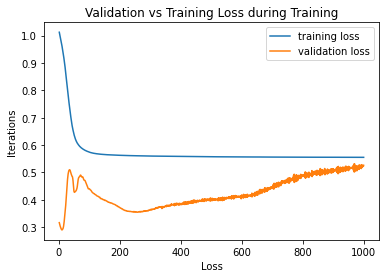

In [28]:
iters = [i+1 for i in range(len(train_loss))]
plt.plot(iters, train_loss ,label = "training loss")
plt.plot(iters, valid_loss, label = "validation loss")
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Validation vs Training Loss during Training')
plt.legend()
plt.show()

In [29]:
validation_predictions = model.forward(al_val_data,c_val_data).detach().numpy()
test_predictions = model.forward(al_test_data,c_test_data).detach().numpy()
joint_test_labels = joint_test_labels.detach().numpy()
joint_valid_labels = joint_valid_labels.detach().numpy()

In [30]:
index_1 = [i+1 for i in range(len(validation_predictions))]
index_2 = [i+1 for i in range(len(test_predictions))]

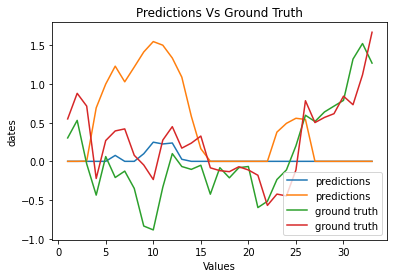

In [31]:
plt.plot(index_1, validation_predictions ,label = "predictions")
plt.plot(index_1, joint_valid_labels, label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

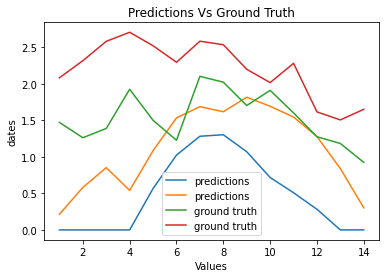

In [32]:
plt.plot(index_2, test_predictions ,label = "predictions")
plt.plot(index_2, joint_test_labels, label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

In [33]:
print(joint_test_labels.shape)
print(test_predictions.shape)

(14, 2)
(14, 2)


In [34]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(joint_test_labels,test_predictions)))
print("Root Mean Squared Error : " + str(utils.rmse(test_predictions, joint_test_labels)))

Mean Directional Accuracy: 0.6538461538461539
Root Mean Squared Error : 1.1869522716349636


In [35]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(joint_valid_labels,validation_predictions)))
print("Root Mean Squared Error : " + str(utils.rmse(validation_predictions, joint_valid_labels)))

Mean Directional Accuracy: 0.484375
Root Mean Squared Error : 0.7251945281786807
